# Setup

In [1]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.explain import Explainer, CaptumExplainer,ModelConfig,GNNExplainer

In [2]:
data_folder = "../../data/processed/graph_data_nohubs/"
models_folder = "../../data/models/"
experiments_folder = "../../data/experiments/design_space_experiment/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append("../..")
from src.models.base_model import base_model

# Utility

In [3]:
# from torch_geometric.nn import SAGEConv,GATConv, to_hetero

import torch
from torch_geometric.nn import SAGEConv,GATConv, to_hetero

class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,edge_index,apply_sigmoid=True):
        nodes_src = x_source[edge_index[0]]
        nodes_trg = x_target[edge_index[1]]
        pred = (nodes_src * nodes_trg).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

class base_message_layer(torch.nn.Module):

    def __init__(self, model_params,hidden_layer=True):
        super().__init__()

        # Currently SageConv or GATConv, might have to modify this to support other Convs
        conv_type = model_params["conv_type"]
        self.conv = layer_dict[conv_type]((-1,-1), model_params["hidden_channels"],aggr=model_params["micro_aggregation"],add_self_loops=False)
        self.normalize = model_params["L2_norm"]

        post_conv_modules = []
        if model_params["batch_norm"]:
            bn = torch.nn.BatchNorm1d(model_params["hidden_channels"])
            post_conv_modules.append(bn)
        
        if model_params["dropout"] > 0:    
            dropout = torch.nn.Dropout(p=model_params["dropout"])
            post_conv_modules.append(dropout)
        
        # No activation on final embedding layer
        if hidden_layer:
            activation = model_params["activation"]()
            post_conv_modules.append(activation)
        
        self.post_conv = torch.nn.Sequential(*post_conv_modules)

    def forward(self, x:dict, edge_index:dict) -> dict:
        x = self.conv(x,edge_index)
        x = self.post_conv(x)
        if self.normalize:
            x = torch.nn.functional.normalize(x,2,-1)
        return x

class multilayer_message_passing(torch.nn.Module):
    #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
    def __init__(self,num_layers,model_params,metadata):
        super().__init__()

        self.skip = model_params["layer_connectivity"]
        self.num_layers = num_layers

        for i in range(self.num_layers):
            hidden_layer = i != self.num_layers-1
            layer = to_hetero(base_message_layer(model_params,hidden_layer),metadata,model_params["macro_aggregation"])
            self.add_module(f"Layer_{i}",layer)
    
    def hetero_skipsum(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = x_val + x_i_val
            x_transformed[key] = transformed_val

        return x_transformed

    def hetero_skipcat(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = torch.cat([x_val,x_i_val],dim=-1)
            x_transformed[key] = transformed_val

        return x_transformed
    
    def forward(self, x:dict, edge_index:dict) -> dict:
        for i, layer in enumerate(self.children()):
            x_i = x
            x = layer(x,edge_index)
            if self.skip == "skipsum":
                x = self.hetero_skipsum(x,x_i)
            elif self.skip == "skipcat" and i < self.num_layers -1:
                x = self.hetero_skipcat(x,x_i)
        
        return x 

class MLP(torch.nn.Module):
    def __init__(self,num_layers,in_dim,out_dim,model_params,hidden_dim=None):
        super().__init__()

        hidden_dim = out_dim if hidden_dim is None else hidden_dim
        
        modules = []
        if num_layers == 1:
            modules.append(torch.nn.Linear(in_dim,out_dim))
        else:
            for i in range(num_layers):
                final_layer = i == num_layers-1
                first_layer = i == 0
                if first_layer:
                    modules.append(torch.nn.Linear(in_dim,hidden_dim))
                    modules.append(model_params["activation"]())
                elif final_layer:
                    modules.append(torch.nn.Linear(hidden_dim,out_dim))
                else:
                    modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
                    modules.append(model_params["activation"]())
        
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self,x):
        x = self.model(x)
        return x

class base_encoder(torch.nn.Module):
    def __init__(self,model_params,metadata):
        super().__init__()

        self.has_pre_mlp = model_params["pre_process_layers"] > 0
        self.has_post_mlp = model_params["post_process_layers"] > 0

        if self.has_pre_mlp:
            self.pre_mlp = to_hetero(MLP(model_params["pre_process_layers"],model_params["feature_dim"],model_params["hidden_channels"],model_params),metadata)
        
        self.message_passing = multilayer_message_passing(model_params["msg_passing_layers"],model_params,metadata)

        if self.has_post_mlp:
            self.post_mlp = to_hetero(MLP(model_params["post_process_layers"],model_params["hidden_channels"],model_params["hidden_channels"],model_params),metadata)
    
    def forward(self,x:dict,edge_index:dict) -> dict :
        if self.has_pre_mlp:
            x = self.pre_mlp(x)

        x = self.message_passing(x,edge_index)
        
        if self.has_post_mlp:
            x = self.post_mlp(x)

        return x

class base_model(torch.nn.Module):
    def __init__(self, model_params,metadata):
        super().__init__()

        default_model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":False,
            "feature_dim": 10,
            "pre_process_layers":0,
            "msg_passing_layers":2,
            "post_process_layers":0,
        }
        
        for arg in default_model_params:
            if arg not in model_params:
                model_params[arg] = default_model_params[arg]
        
        self.encoder = base_encoder(model_params,metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
    
    def decode(self,x:dict,edge_label_index:dict,supervision_types):
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            src_type = edge_type[0]
            trg_type = edge_type[2]

            x_src = x[src_type]
            x_trg = x[trg_type]

            pred = self.decoder(x_src,x_trg,edge_index)

            pred_dict[edge_type] = pred
        
        return pred_dict
    
    def encode(self,data):
        x = data.x_dict
        adj_t = data.adj_t_dict

        encodings = self.encoder(x,adj_t)
        return encodings
    
    def forward(self,x,adj_t,edge_label_index,supervision_types,return_tensor=False):
        # x = data.x_dict
        # adj_t = data.adj_t_dict
        # edge_label_index = data.edge_label_index_dict

        x = self.encoder(x,adj_t)
        pred = self.decode(x,edge_label_index,supervision_types)
        if return_tensor:
            pred = pred[supervision_types[0]]
        return pred

    def loss(self, prediction_dict, label_dict):
        loss = 0
        num_types = len(prediction_dict.keys())
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss/num_types

layer_dict = {
    "GATConv":GATConv,
    "SAGEConv":SAGEConv
}

In [3]:
import copy

def load_data(folder_path,load_test = False,load_full=False):
    if load_test:
        names = ["train","validation","test"]
    else:
        names = ["train","validation"]
    datasets = []
    for name in names:
        path = folder_path+name+".pt"
        datasets.append(torch.load(path))
    
    return datasets

def initialize_features(data,feature,dim,inplace=False):
    if inplace:
        data_object = data
    else:
        data_object = copy.copy(data)
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

def load_model(state_dict,params,metadata):
    model = base_model(params,metadata,supervision_types=[('gene_protein', 'gda', 'disease')])
    model.load_state_dict(state_dict)
    return model

def load_experiment(eid:int,date:str,metadata:tuple) -> tuple:
    """Returns tuple (model,params).
    date format: d_m_y"""
    df_path = f"{experiments_folder}experiment_{date}.parquet"
    weights_path = f"{experiments_folder}experiment_{eid}_{date}__.pth"

    df = pd.read_parquet(df_path)
    #TODO: this is only temporal, remove after fix
    df["conv_type"] = df.conv_type.apply(lambda x: x.split(".")[-1].rstrip("\'>"))
    df["activation"] = torch.nn.LeakyReLU
    params = df.loc[eid].to_dict()
    weights = torch.load(weights_path,map_location=torch.device(device))

    model = base_model(params,metadata)
    model.load_state_dict(weights)

    return model,params

def load_node_csv(path, index_col,type_col, **kwargs):
    """Returns node dataframe and a dict of mappings for each node type. 
    Each mapping maps from original df index to "heterodata index" { node_type : { dataframe_index : heterodata_index}}"""
    df = pd.read_csv(path, **kwargs,index_col=index_col)
    node_types = df[type_col].unique()
    mappings_dict = dict()
    for node_type in node_types:
        mapping = {index: i for i, index in enumerate(df[df[type_col] == node_type].index.unique())}
        mappings_dict[node_type] = mapping

    return df,mappings_dict

In [8]:
train_data,val_data = load_data(data_folder+"split_dataset/")
full_data = torch.load(data_folder+"split_dataset/full_dataset.pt")

eid = 34
date = "18_04_23"
model,params = load_experiment(eid,date,train_data.metadata())

train_data = initialize_features(train_data,params["feature_type"],params["feature_dim"])
val_data = initialize_features(train_data,params["feature_type"],params["feature_dim"])
full_data = initialize_features(full_data,params["feature_type"],params["feature_dim"])

AttributeError: 'inner_product_decoder' object has no attribute '_load_state_dict_pre_hooks'

In [70]:
import torch_geometric.transforms as T
transf = T.ToSparseTensor(remove_edge_index=False)
full_data = transf(full_data)

In [31]:
x = train_data.x_dict
adj_t = train_data.adj_t_dict
edge_index = train_data.edge_index_dict
edge_label_index = train_data.edge_label_index_dict
# edge_label_index = train_data["gene_protein","disease"].edge_label_index

In [32]:
supervision_types = [('gene_protein', 'gda', 'disease')]
with torch.no_grad():
    model.eval()
    prediction = model(x,adj_t,edge_label_index,supervision_types,True)

In [59]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=None
)

In [ ]:
def explainer_forward(model,data)

In [54]:
prediction = explainer.get_prediction(x,edge_index,edge_label_index,supervision_types,return_tensor=True)
target = explainer.get_target(prediction)

In [52]:
prediction.view(-1)

tensor([0.3982, 0.7912, 0.8521,  ..., 0.4634, 0.0412, 0.0242])

In [60]:
explainer(x,edge_index,edge_label_index=edge_label_index,supervision_types=supervision_types,return_tensor=True)

AssertionError: Tensor target dimension torch.Size([1, 26884]) is not valid. torch.Size([26884])

In [230]:
explainer(x,edge_index,edge_label_index=edge_label_index)

TypeError: 'IntegratedGradients' object is not callable

In [160]:
explainer.algorithm.attribution_method

TypeError: 'IntegratedGradients' object is not callable

In [156]:
explainer.algorithm(model,x,edge_index,edge_label_index=edge_label_index,target=target)

TypeError: 'IntegratedGradients' object is not callable

In [138]:
from torch_geometric.explain.algorithm.captum import CaptumHeteroModel
from torch_geometric.nn import to_captum_model

In [139]:
captum_model = to_captum_model(model)

In [142]:
explainer.algorithm.attribution_method

In [128]:
explainer.algorithm.attribution_method()

TypeError: 'IntegratedGradients' object is not callable

In [113]:
explainer.algorithm.supports()

True

In [144]:
explainer(x,adj_t,edge_index)

TypeError: Explainer.__call__() takes 3 positional arguments but 4 were given

In [94]:
explainer(x,edge_index,edge_label_index=edge_label_index)

AssertionError: Tensor target dimension torch.Size([1, 26884]) is not valid. torch.Size([1, 26884])

In [12]:
model_config = ModelConfig(
    mode='binary_classification',
    task_level='edge',
    return_type='raw',
)

explainer = Explainer(
    model,  # It is assumed that model outputs a single tensor.
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config = model_config
)

hetero_explanation = explainer(
    train_data.x_dict,
    train_data.edge_index_dict,
    index=torch.tensor([1, 3]),
)
print(hetero_explanation.edge_mask_dict)
print(hetero_explanation.node_mask_dict)


AttributeError: 'dict' object has no attribute 'x_dict'

# Trying simpler model

In [4]:
import training_utils as util

In [5]:
import torch
from torch_geometric.nn import SAGEConv,GATConv, to_hetero

class inner_product_decoder(torch.nn.Module):
    def forward(self,x_dict,edge_label_index,supervision_types,apply_sigmoid=True):
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            src_type = edge_type[0]
            trg_type = edge_type[2]

            x_src = x_dict[src_type]
            x_trg = x_dict[trg_type]

            nodes_src = x_src[edge_index[0]]
            nodes_trg = x_trg[edge_index[1]]
            pred = (nodes_src * nodes_trg).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        pred_dict[edge_type] = pred
        
        return pred_dict

class base_message_layer(torch.nn.Module):

    def __init__(self, model_params,hidden_layer=True):
        super().__init__()

        # Currently SageConv or GATConv, might have to modify this to support other Convs
        conv_type = model_params["conv_type"]
        self.conv = layer_dict[conv_type]((-1,-1), model_params["hidden_channels"],aggr=model_params["micro_aggregation"],add_self_loops=False)
        self.normalize = model_params["L2_norm"]

        post_conv_modules = []
        if model_params["batch_norm"]:
            bn = torch.nn.BatchNorm1d(model_params["hidden_channels"])
            post_conv_modules.append(bn)
        
        if model_params["dropout"] > 0:    
            dropout = torch.nn.Dropout(p=model_params["dropout"])
            post_conv_modules.append(dropout)
        
        # No activation on final embedding layer
        if hidden_layer:
            activation = model_params["activation"]()
            post_conv_modules.append(activation)
        
        self.post_conv = torch.nn.Sequential(*post_conv_modules)

    def forward(self, x:dict, edge_index:dict) -> dict:
        x = self.conv(x,edge_index)
        x = self.post_conv(x)
        if self.normalize:
            x = torch.nn.functional.normalize(x,2,-1)
        return x

class multilayer_message_passing(torch.nn.Module):
    #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
    def __init__(self,num_layers,model_params,metadata):
        super().__init__()

        self.skip = model_params["layer_connectivity"]
        self.num_layers = num_layers

        for i in range(self.num_layers):
            hidden_layer = i != self.num_layers-1
            layer = to_hetero(base_message_layer(model_params,hidden_layer),metadata,model_params["macro_aggregation"])
            self.add_module(f"Layer_{i}",layer)
    
    def hetero_skipsum(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = x_val + x_i_val
            x_transformed[key] = transformed_val

        return x_transformed

    def hetero_skipcat(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = torch.cat([x_val,x_i_val],dim=-1)
            x_transformed[key] = transformed_val

        return x_transformed
    
    def forward(self, x:dict, edge_index:dict) -> dict:
        for i, layer in enumerate(self.children()):
            x_i = x
            x = layer(x,edge_index)
            if self.skip == "skipsum":
                x = self.hetero_skipsum(x,x_i)
            elif self.skip == "skipcat" and i < self.num_layers -1:
                x = self.hetero_skipcat(x,x_i)
        
        return x 

class MLP(torch.nn.Module):
    def __init__(self,num_layers,in_dim,out_dim,model_params,hidden_dim=None):
        super().__init__()

        hidden_dim = out_dim if hidden_dim is None else hidden_dim
        
        modules = []
        if num_layers == 1:
            modules.append(torch.nn.Linear(in_dim,out_dim))
        else:
            for i in range(num_layers):
                final_layer = i == num_layers-1
                first_layer = i == 0
                if first_layer:
                    modules.append(torch.nn.Linear(in_dim,hidden_dim))
                    modules.append(model_params["activation"]())
                elif final_layer:
                    modules.append(torch.nn.Linear(hidden_dim,out_dim))
                else:
                    modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
                    modules.append(model_params["activation"]())
        
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self,x):
        x = self.model(x)
        return x

class base_encoder(torch.nn.Module):
    def __init__(self,model_params,metadata):
        super().__init__()

        self.has_pre_mlp = model_params["pre_process_layers"] > 0
        self.has_post_mlp = model_params["post_process_layers"] > 0

        if self.has_pre_mlp:
            self.pre_mlp = to_hetero(MLP(model_params["pre_process_layers"],model_params["feature_dim"],model_params["hidden_channels"],model_params),metadata)
        
        self.message_passing = multilayer_message_passing(model_params["msg_passing_layers"],model_params,metadata)

        if self.has_post_mlp:
            self.post_mlp = to_hetero(MLP(model_params["post_process_layers"],model_params["hidden_channels"],model_params["hidden_channels"],model_params),metadata)
    
    def forward(self,x:dict,edge_index:dict) -> dict :
        if self.has_pre_mlp:
            x = self.pre_mlp(x)

        x = self.message_passing(x,edge_index)
        
        if self.has_post_mlp:
            x = self.post_mlp(x)

        return x

class base_model_test(torch.nn.Module):
    def __init__(self, model_params,metadata,supervision_types = [('gene_protein', 'gda', 'disease')]):
        super().__init__()

        default_model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":False,
            "feature_dim": 10,
            "pre_process_layers":0,
            "msg_passing_layers":2,
            "post_process_layers":0,
        }
        
        for arg in default_model_params:
            if arg not in model_params:
                model_params[arg] = default_model_params[arg]
        
        self.encoder = base_encoder(model_params,metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
        self.supervision_types = supervision_types
    
    def forward(self,x,adj_t,edge_label_index,return_tensor=True):
        """adj_t_dict or edge_index_dict are valid options. adj_t is recommended for training"""

        x = self.encoder(x,adj_t)
        pred = self.decoder(x,edge_label_index,self.supervision_types)

        if return_tensor:
            pred = pred[supervision_types[0]]
        return pred

    def loss(self, prediction, labels):
        loss = 0

        if type(prediction) == dict:
            for edge_type,pred in prediction.items():
                y = labels[edge_type]
                loss += self.loss_fn(pred, y.type(pred.dtype))
        else:
            y = labels[self.supervision_types[0]]
            loss += self.loss_fn(prediction, y.type(prediction.dtype))

        return loss

layer_dict = {
    "GATConv":GATConv,
    "SAGEConv":SAGEConv
}

In [7]:
train_data,val_data = load_data(data_folder+"split_dataset/")
full_data = torch.load(data_folder+"split_dataset/full_dataset.pt")

In [10]:
params = {'hidden_channels': 32,
 'conv_type': "SAGEConv",
 'batch_norm': True,
 'dropout': 0.1,
 'activation': torch.nn.LeakyReLU,
 'micro_aggregation': 'sum',
 'macro_aggregation': 'sum',
 'layer_connectivity': None,
 'L2_norm': True,
 'pre_process_layers': 0,
 'msg_passing_layers': 2,
 'post_process_layers': 0,
 'feature_dim': 10,
 'feature_type': 'ones',
 'weight_decay': 0.001,
 'lr': 0.001,
 'epochs': 100,
 'patience': 5,
 'delta': 0.01}

train_set = initialize_features(train_data,params["feature_type"],params["feature_dim"])
val_set = initialize_features(train_data,params["feature_type"],params["feature_dim"])
full_data = initialize_features(full_data,params["feature_type"],params["feature_dim"])

model = base_model_test(params,train_set.metadata())

In [11]:
def get_input(heterodata):
    x = heterodata.x_dict
    adj_t = heterodata.adj_t_dict
    edge_label_index = heterodata.edge_label_index_dict
    edge_label = heterodata.edge_label_dict

    return x,adj_t,edge_label_index,edge_label

In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

@torch.no_grad()
def hits_at_k(y_true,x_prob,k,key) -> dict:
    """Dados los tensores x_prob y edge_label, calcula cuantas predicciones hizo correctamente en los primeros k puntajes.
    x_prob es la predicción del modelo luego de aplicar sigmoid (sin redondear, osea, el puntaje crudo)"""

    #ordeno los puntajes de mayor a menor
    x_prob, indices = torch.sort(x_prob, descending=True)

    #me quedo solo con los k mayor punteados
    x_prob = x_prob[:k]
    indices = indices[:k]

    if any(x_prob < 0.5):
      threshold_index = (x_prob < 0.5).nonzero()[0].item()
      print(f"Top {k} scores for {key} below classification threshold 0.5, threshold index: {threshold_index}")

    #busco que label tenían esas k preds
    labels = y_true[indices]

    #cuento cuantas veces predije uno positivo en el top k
    hits = labels.sum().item()

    return hits

def train(model, optimizer, graph):
    model.train()
    optimizer.zero_grad()
    x,adj_t,edge_label_index,edge_label = get_input(graph)

    preds = model(x,adj_t,edge_label_index)
    loss = model.loss(preds, edge_label)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def get_val_loss(model,val_data):
    model.eval()
    x,adj_t,edge_label_index,edge_label = get_input(val_data)
    
    preds = model(x,adj_t,edge_label_index)
    loss = model.loss(preds, edge_label)

    return loss.item()

def get_metrics(y_true, x_pred):
   acc = round(accuracy_score(y_true,x_pred),2)
   ap = round(average_precision_score(y_true, x_pred),2)
   roc_auc = round(roc_auc_score(y_true,x_pred),2)

   return acc,ap ,roc_auc
  
@torch.no_grad()
def test(model,data,metric):
  model.eval()
  x,adj_t,edge_label_index,edge_label = get_input(data)
  
  preds = model(x,adj_t,edge_label_index)

  if type(preds) == dict:
    all_preds = []
    all_true = []
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        all_preds.append(pred_label)
        all_true.append(ground_truth)
    total_predictions = torch.cat(all_preds, dim=0).cpu().numpy()
    total_true = torch.cat(all_true, dim=0).cpu().numpy()
    score = metric(total_true,total_predictions)
  else:
    pred_label = torch.round(preds)
    ground_truth = edge_label[model.supervision_types[0]]
    score = metric(ground_truth,pred_label)
  return score
  

@torch.no_grad()
def full_test(model,data,k,global_score=True):
  model.eval()
  x,adj_t,edge_label_index,edge_label = get_input(data)

  preds = model(x,adj_t,edge_label_index)
  metrics = {}

  if global_score:
    all_scores = []
    all_preds = []
    all_true = []
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        all_scores.append(pred)
        all_preds.append(pred_label)
        all_true.append(ground_truth)

    total_predictions = torch.cat(all_preds, dim=0)
    total_true = torch.cat(all_true, dim=0)
    total_scores = torch.cat(all_scores,dim=0)

    acc, ap, roc_auc =  get_metrics(total_true.cpu().numpy(), total_predictions.cpu().numpy())
    hits_k = hits_at_k(total_true,total_scores,k,"all")
    metrics["all"] = [acc,ap,roc_auc,hits_k]

  else:
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label_index[key]
        acc, ap, roc_auc = get_metrics(ground_truth.cpu().numpy(), pred_label.cpu().numpy())
        hits_k = hits_at_k(ground_truth,pred,k,key)
        metrics[key] = [acc,ap, roc_auc,hits_k]
  
  return metrics

0.5303047299385071
0.4939281940460205


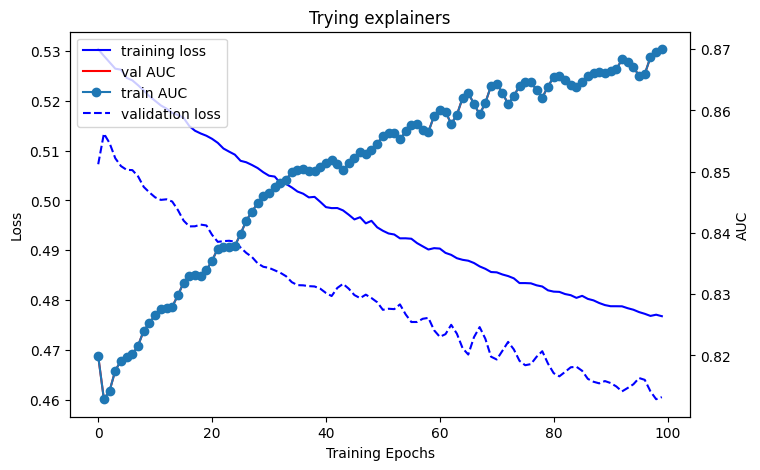

In [14]:
from sklearn.metrics import roc_auc_score

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params["weight_decay"])
train_losses = []
val_losses = []
train_scores = []
val_scores = []

metric = roc_auc_score
epochs = params["epochs"]

early_stopper = util.EarlyStopper(params["patience"],params["delta"])
for epoch in range(epochs):
    supervision_types = model.supervision_types
    train_loss = train(model,optimizer,train_set)
    val_loss = get_val_loss(model,val_set)
    train_score = test(model,train_set,metric)
    val_score = test(model,val_set,metric)

    train_losses.append(train_loss)
    train_scores.append(train_score)
    val_scores.append(val_score)
    val_losses.append(val_loss)

    if epoch%50 == 0:
        print(train_loss)
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping")
        break

val_auc = test(model,val_set,roc_auc_score)
curve_data = [train_losses,val_losses,train_scores,val_scores]

util.plot_training_stats("Trying explainers", *curve_data,"AUC")

In [155]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=None
)

In [15]:
x,adj_t,edge_label_index,edge_label = get_input(train_set)
edge_index = train_set.edge_index_dict
supervision_types = model.supervision_types

In [23]:
with torch.no_grad():
    model.eval()
    pred = model(x,adj_t,edge_label_index)
    target = torch.round(pred)

In [69]:
from captum.attr import IntegratedGradients

from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv
from torch_geometric.nn import (captum_output_to_dicts,
                                to_captum_model, to_captum_input)

data = train_set
y = target
...  # Train the model.

# Explain predictions for node `10`:
mask_type="edge"
metadata = data.metadata()
output_idx = 10
captum_model = to_captum_model(model, mask_type, metadata)
inputs, additional_forward_args = to_captum_input(data.x_dict,
                                    data.edge_index_dict, mask_type)

ig = IntegratedGradients(captum_model)
ig_attr = ig.attribute(inputs=inputs)
edge_attr_dict = captum_output_to_dicts(ig_attr, mask_type, metadata)

AssertionError: Dimension 0 of input should be 1

In [70]:
[a.shape for a in inputs]

[torch.Size([1, 53770]),
 torch.Size([1, 27292]),
 torch.Size([1, 140866]),
 torch.Size([1, 53770]),
 torch.Size([1, 27292]),
 torch.Size([1, 5217]),
 torch.Size([1, 10032]),
 torch.Size([1, 1208]),
 torch.Size([1, 1208]),
 torch.Size([1, 5217]),
 torch.Size([1, 576])]

In [73]:
[a.shape for a in edge_index.values()]

[torch.Size([2, 53770]),
 torch.Size([2, 27292]),
 torch.Size([2, 140866]),
 torch.Size([2, 53770]),
 torch.Size([2, 27292]),
 torch.Size([2, 5217]),
 torch.Size([2, 10032]),
 torch.Size([2, 1208]),
 torch.Size([2, 1208]),
 torch.Size([2, 5217]),
 torch.Size([2, 576])]

In [169]:
train_data.edge_index_dict[('disease', 'gda', 'gene_protein')]

tensor([[    0,    73,   449,  ...,   591,   195,     3],
        [    0,     3,     3,  ..., 17317, 17320, 17321]])

In [165]:
for module in model.modules():
    if isinstance(module, torch.nn.ModuleDict):
        for edge_type in edge_types:
            # TODO (jinu) Use common function get `str_edge_type`.
            str_edge_type = '__'.join(edge_type)
            if str_edge_type in module:
                print(str_edge_type)
                # set_masks(
                #     module[str_edge_type],
                #     mask_dict[edge_type],
                #     edge_index_dict[edge_type],
                #     apply_sigmoid=apply_sigmoid,
                # )

disease__gda__gene_protein
pathway__pathway_protein__gene_protein
gene_protein__ppi__gene_protein
gene_protein__gda__disease
gene_protein__pathway_protein__pathway
bert_group__disease_disease__disease
disease__disease_disease__disease
complex__form_complex__gene_protein
gene_protein__form_complex__complex
disease__disease_disease__bert_group
bert_group__disease_disease__bert_group
disease__gda__gene_protein
pathway__pathway_protein__gene_protein
gene_protein__ppi__gene_protein
gene_protein__gda__disease
gene_protein__pathway_protein__pathway
bert_group__disease_disease__disease
disease__disease_disease__disease
complex__form_complex__gene_protein
gene_protein__form_complex__complex
disease__disease_disease__bert_group
bert_group__disease_disease__bert_group


In [139]:
model.modules()

<generator object Module.modules at 0x7f9f477460a0>

In [151]:
from torch_geometric.nn import MessagePassing
for module in model.modules():
    if isinstance(module, torch.nn.ModuleDict):
        if any([isinstance(submodule, MessagePassing) for submodule in module.modules()]):
            print(module)

ModuleDict(
  (disease__gda__gene_protein): SAGEConv((-1, -1), 32, aggr=sum)
  (pathway__pathway_protein__gene_protein): SAGEConv((-1, -1), 32, aggr=sum)
  (gene_protein__ppi__gene_protein): SAGEConv((-1, -1), 32, aggr=sum)
  (gene_protein__gda__disease): SAGEConv((-1, -1), 32, aggr=sum)
  (gene_protein__pathway_protein__pathway): SAGEConv((-1, -1), 32, aggr=sum)
  (bert_group__disease_disease__disease): SAGEConv((-1, -1), 32, aggr=sum)
  (disease__disease_disease__disease): SAGEConv((-1, -1), 32, aggr=sum)
  (complex__form_complex__gene_protein): SAGEConv((-1, -1), 32, aggr=sum)
  (gene_protein__form_complex__complex): SAGEConv((-1, -1), 32, aggr=sum)
  (disease__disease_disease__bert_group): SAGEConv((-1, -1), 32, aggr=sum)
  (bert_group__disease_disease__bert_group): SAGEConv((-1, -1), 32, aggr=sum)
)
ModuleDict(
  (disease__gda__gene_protein): SAGEConv((-1, -1), 32, aggr=sum)
  (pathway__pathway_protein__gene_protein): SAGEConv((-1, -1), 32, aggr=sum)
  (gene_protein__ppi__gene_pro

In [122]:
edge_index[('disease', 'gda', 'gene_protein')]

tensor([[    0,    73,   449,  ...,   591,   195,     3],
        [    0,     3,     3,  ..., 17317, 17320, 17321]])

In [121]:
edge_label_index

{('gene_protein',
  'ppi',
  'gene_protein'): tensor([[ 2273,  6410,  6484,  ..., 13032,   373,  1754],
         [ 4571,  6415, 15631,  ...,  8002,  1884,  8391]]),
 ('gene_protein',
  'gda',
  'disease'): tensor([[ 2929,  6037,  4913,  ...,  3391, 15286,  7687],
         [  870,  4171,  4728,  ...,  7081,  7141, 11498]]),
 ('gene_protein',
  'pathway_protein',
  'pathway'): tensor([[ 9712,  4875,  4179,  ..., 13283,  4048, 13984],
         [ 1187,   346,  1114,  ...,  1427,  1433,   357]]),
 ('disease',
  'disease_disease',
  'disease'): tensor([[  657,  1656, 11957,  ..., 13357, 12671,  9112],
         [14177,  8655, 14882,  ...,  6576,   112,  8946]]),
 ('gene_protein',
  'form_complex',
  'complex'): tensor([[ 5333,   300,  2020,  ..., 11341, 16312,  6904],
         [   10,   116,    45,  ...,   154,   112,   309]]),
 ('disease',
  'disease_disease',
  'bert_group'): tensor([[  603,  7474,  8560,  ..., 13647, 12388, 13596],
         [  654,   622,   791,  ...,   210,   945,   756]]

In [170]:
import torch

from torch_geometric.explain.algorithm.utils import (
    clear_masks,
    set_hetero_masks,
)
from torch_geometric.nn import GCNConv, HeteroConv, SAGEConv, to_hetero


class HeteroModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = HeteroConv({
            ('paper', 'to', 'paper'):
            GCNConv(-1, 32),
            ('author', 'to', 'paper'):
            SAGEConv((-1, -1), 32),
            ('paper', 'to', 'author'):
            SAGEConv((-1, -1), 32),
        })

        self.conv2 = HeteroConv({
            ('paper', 'to', 'paper'):
            GCNConv(-1, 32),
            ('author', 'to', 'paper'):
            SAGEConv((-1, -1), 32),
            ('paper', 'to', 'author'):
            SAGEConv((-1, -1), 32),
        })


class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 32)
        self.conv2 = SAGEConv((-1, -1), 32)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


def test_set_clear_mask(hetero_data):
    edge_mask_dict = {
        ('paper', 'to', 'paper'): torch.ones(200),
        ('author', 'to', 'paper'): torch.ones(100),
        ('paper', 'to', 'author'): torch.ones(100),
    }

    model = HeteroModel()

    set_hetero_masks(model, edge_mask_dict, hetero_data.edge_index_dict)
    for edge_type in hetero_data.edge_types:
        # Check that masks are correctly set:
        str_edge_type = '__'.join(edge_type)
        assert torch.allclose(model.conv1.convs[str_edge_type]._edge_mask,
                              edge_mask_dict[edge_type])
        assert model.conv1.convs[str_edge_type].explain

    clear_masks(model)
    for edge_type in hetero_data.edge_types:
        str_edge_type = '__'.join(edge_type)
        assert model.conv1.convs[str_edge_type]._edge_mask is None
        assert not model.conv1.convs[str_edge_type].explain

    model = to_hetero(GraphSAGE(), hetero_data.metadata(), debug=False)

    set_hetero_masks(model, edge_mask_dict, hetero_data.edge_index_dict)
    for edge_type in hetero_data.edge_types:
        # Check that masks are correctly set:
        str_edge_type = '__'.join(edge_type)
        assert torch.allclose(model.conv1[str_edge_type]._edge_mask,
                              edge_mask_dict[edge_type])
        assert model.conv1[str_edge_type].explain

    clear_masks(model)
    for edge_type in hetero_data.edge_types:
        str_edge_type = '__'.join(edge_type)
        assert model.conv1[str_edge_type]._edge_mask is None
        assert not model.conv1[str_edge_type].explain